In [1]:
#Importing required libraries
import keras, os
import numpy as np
import tensorflow as tf
from keras.datasets import cifar100
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPool2D, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import optimizers
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras import backend as K
from keras import regularizers

In [2]:
train=True
num_classes = 100

In [3]:
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train=x_train/255.0
x_test=x_test/255.0

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

169009152/169001437 [==============================] - 6s 0us/step


In [4]:
# Model Summary
input = keras.layers.Input(shape=(32,32,3))

model = keras.layers.Conv2D(filters=64,kernel_size=3, padding='same')(input)
model = keras.layers.Conv2D(filters=64,kernel_size=3, padding='same')(model)
model = keras.layers.LeakyReLU()(model)
model = keras.layers.MaxPool2D(pool_size=2)(model)

model = keras.layers.Conv2D(filters=128,kernel_size=3, padding='same')(model)
model = keras.layers.Conv2D(filters=128,kernel_size=3, padding='same')(model)
model = keras.layers.LeakyReLU()(model)
model = keras.layers.MaxPool2D(pool_size=2)(model)

model = keras.layers.Conv2D(filters=256,kernel_size=3, padding='same')(model)
model = keras.layers.Conv2D(filters=256,kernel_size=3, padding='same')(model)
model = keras.layers.Conv2D(filters=256,kernel_size=3, padding='same')(model)
model = keras.layers.LeakyReLU()(model)
model = keras.layers.MaxPool2D(pool_size=2)(model)


flat = keras.layers.Flatten()(model)
fc1 = Dense(units=2048)(flat)
fc1 = keras.layers.ReLU()(fc1)

fc2 = Dense(units=1024)(fc1)
fc1 = keras.layers.ReLU()(fc1)

out = Dense(units=100, activation='softmax')(fc2)
model = keras.Model(input,out)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)      

In [5]:
# Optimization Details
opt = Adam(lr=0.0001, decay = 1e-6)
model.compile(optimizer= opt, loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

In [6]:
from keras.metrics import Precision, Recall
batch_size = 128


checkpoint = ModelCheckpoint("vggnoreg.h5", monitor='val_accuracy', verbose=2, save_best_only=True, save_weights_only=True, mode='auto')
early = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=2, mode='auto')


# Data Augmentation
datagen = ImageDataGenerator(width_shift_range = 0.2,
                             height_shift_range = 0.2,
                             rotation_range = 10,
                             zoom_range = 0.2,
                             horizontal_flip = True,
                             vertical_flip = True,
                             fill_mode = 'nearest')

hist = model.fit_generator(datagen.flow(x_train, y_train,
                                 batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=100,
                    validation_data=(x_test, y_test),callbacks=[checkpoint, early],verbose=2)
model.save_weights('vggnoreg.h5') 

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100

Epoch 00001: val_accuracy improved from -inf to 0.14240, saving model to vggnoreg.h5
390/390 - 25s - loss: 4.0156 - accuracy: 0.0860 - precision: 0.4556 - recall: 0.0047 - val_loss: 3.5974 - val_accuracy: 0.1424 - val_precision: 0.5614 - val_recall: 0.0160
Epoch 2/100

Epoch 00002: val_accuracy improved from 0.14240 to 0.21020, saving model to vggnoreg.h5
390/390 - 25s - loss: 3.4888 - accuracy: 0.1673 - precision: 0.5582 - recall: 0.0209 - val_loss: 3.2552 - val_accuracy: 0.2102 - val_precision: 0.6145 - val_recall: 0.0483
Epoch 3/100

Epoch 00003: val_accuracy improved from 0.21020 to 0.26230, saving model to vggnoreg.h5
390/390 - 24s - loss: 3.2528 - accuracy: 0.2111 - precision: 0.6077 - recall: 0.0409 - val_loss: 2.9743 - val_accuracy: 0.2623 - val_precision: 0.6397 - val_recall: 0.0813
Epoch 4/100

Epoch 00004: val_accuracy improved from 0.26230 to 0.28940, saving model to vggnoreg.h5
390/390

In [7]:
#Loading model
model.load_weights(filepath = 'vggnoreg.h5')
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
print("Precison: %.2f%%" % (scores[2]*100))
print("Recall: %.2f%%" % (scores[3]*100))

Accuracy: 50.82%
Precison: 64.88%
Recall: 42.45%


Text(0.5, 1.0, 'recall')

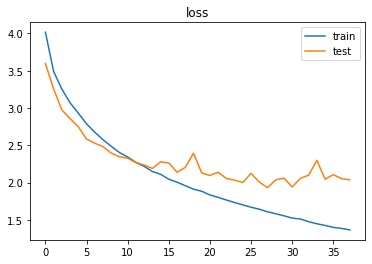

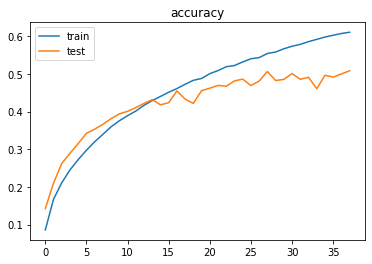

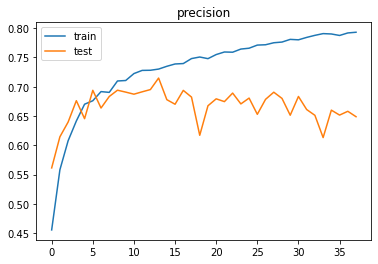

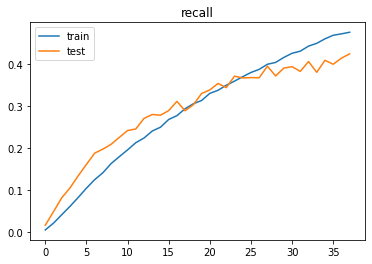

In [8]:
# Plotting loss, accuracy, precision, recall
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['train','test'])
plt.title('loss')
plt.figure()
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['train','test'])
plt.title('accuracy')
plt.figure()
plt.plot(hist.history['precision'])
plt.plot(hist.history['val_precision'])
plt.legend(['train','test'])
plt.title('precision')
plt.figure()
plt.plot(hist.history['recall'])
plt.plot(hist.history['val_recall'])
plt.legend(['train','test'])
plt.title('recall')

In [9]:
# Printing saved weights in numpy arrays
for layer in model.layers: 
  print(layer.get_weights())

[]
[array([[[[-0.03386481, -0.01984516, -0.02065616, ...,  0.06269562,
           0.07622188,  0.07490111],
         [ 0.09014548,  0.10966873,  0.01643694, ..., -0.05560813,
           0.07442372, -0.08162097],
         [ 0.10291925,  0.01387293, -0.03658576, ..., -0.0276317 ,
           0.00617104,  0.02457563]],

        [[ 0.0353465 , -0.07140025,  0.07312115, ...,  0.00782221,
          -0.09208854, -0.12047243],
         [ 0.06001419,  0.08094686,  0.10872564, ...,  0.02775434,
           0.00424655, -0.05197708],
         [-0.05941379,  0.0493401 ,  0.09545681, ..., -0.0465568 ,
           0.00177959, -0.07749017]],

        [[-0.1035568 , -0.06932007, -0.05432936, ...,  0.07013968,
           0.01258431,  0.04000759],
         [-0.09304132,  0.06167933, -0.09993334, ..., -0.08393962,
           0.03392994,  0.09322928],
         [-0.02234936,  0.04424395, -0.08836399, ...,  0.00781014,
           0.04731192, -0.07046375]]],


       [[[ 0.0979412 , -0.0891627 ,  0.01367629, ...